In [ ]:
!python --version

Python 3.10.12


cpu or Tpu

In [ ]:
import torch
torch.__version__

'2.3.0+cu121'

Imporing all libraries

In [ ]:
import os
import random
import pandas
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from tqdm import tqdm
from torch.optim import Adam
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from torch.nn import CrossEntropyLoss
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, random_split
from transformers import ViTForImageClassification, ViTFeatureExtractor, ViTConfig
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


Set to GPU

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

connect to google drive

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


Load train test and validation data

In [ ]:
# Define the transform for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the training dataset
data_dir = 'leukemia'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)

# Calculate the sizes of the train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Optionally, you can also load the test dataset as before
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model defining

Model emplementation

In [ ]:
config = ViTConfig(
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    num_labels=2,  # Assuming binary classification
    image_size=224,
    patch_size=16,
)

# Initialize the model from scratch
model = ViTForImageClassification(config)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize optimizer, loss function, and learning rate scheduler
optimizer = Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
criterion = CrossEntropyLoss()

num_epochs = 20
best_val_loss = float('inf')
patience = 5
counter = 0

train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    correct_train = 0
    for batch in tqdm(train_loader):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += torch.sum(preds == labels).item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / len(train_loader.dataset)
    train_accuracies.append(train_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')


100%|██████████| 275/275 [08:07<00:00,  1.77s/it]


Epoch 1/20, Train Loss: 0.5673, Train Accuracy: 0.7468


100%|██████████| 275/275 [06:39<00:00,  1.45s/it]


Epoch 2/20, Train Loss: 0.4246, Train Accuracy: 0.8201


100%|██████████| 275/275 [06:33<00:00,  1.43s/it]


Epoch 3/20, Train Loss: 0.4068, Train Accuracy: 0.8291


100%|██████████| 275/275 [06:30<00:00,  1.42s/it]


Epoch 4/20, Train Loss: 0.3809, Train Accuracy: 0.8438


 45%|████▌     | 124/275 [02:53<03:29,  1.39s/it]

In [ ]:
model.eval()
val_loss = 0.0
correct_val = 0
with torch.no_grad():
        for batch in tqdm(val_loader):
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += torch.sum(preds == labels).item()
val_loss /= len(val_loader.dataset)
val_accuracy = correct_val / len(val_loader.dataset)
val_losses.append(val_loss)
val_accuracies.append(val_accuracy)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Learning rate scheduling
scheduler.step()

    # Early stopping
if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
           # break

100%|██████████| 31/31 [00:19<00:00,  1.63it/s]


Validation Loss: 0.8411, Validation Accuracy: 0.7566


In [ ]:
model.load_state_dict(torch.load('best_model.pth'))

# Testing phase
model.eval()
test_loss = 0.0
correct_test = 0
true_labels = []
pred_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs).logits
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)

        correct_test += torch.sum(preds == labels).item()
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

test_loss /= len(test_loader.dataset)
test_accuracy = correct_test / len(test_loader.dataset)
test_accuracies.append(test_accuracy)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

100%|██████████| 59/59 [11:26<00:00, 11.64s/it]

Test Loss: 1.1828, Test Accuracy: 0.6529


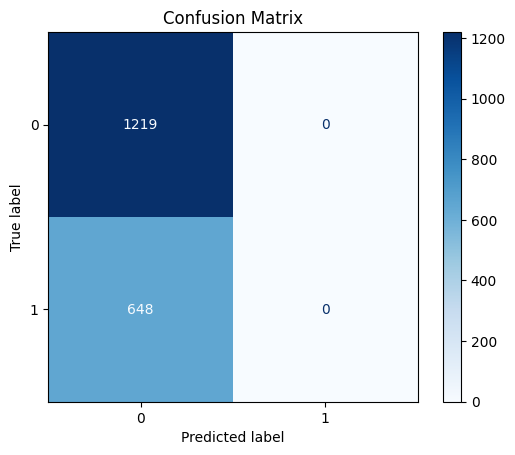

ValueError: x and y must have same first dimension, but have shapes (0,) and (3,)

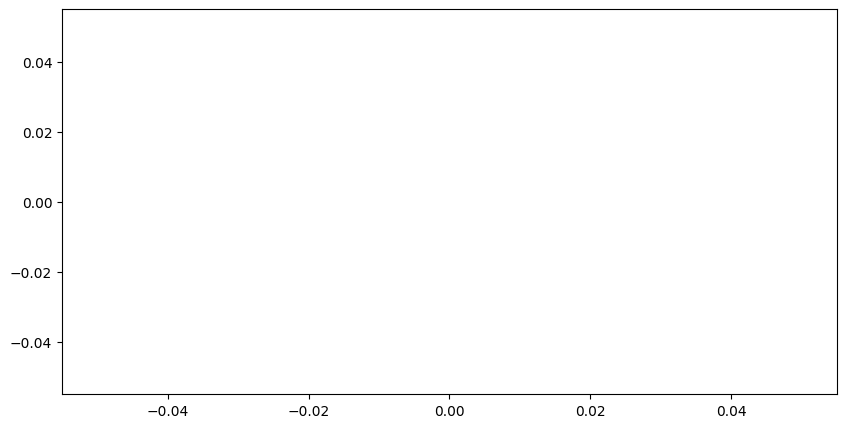

In [ ]:

#Compute and plot confusion matrix
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Plot train, validation, and test accuracies
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.plot(epochs, test_accuracies * len(epochs), label='Test Accuracy')  # Extend test accuracy to all epochs for visualization
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train, Validation, and Test Accuracy')
plt.legend()
plt.show()

# Plot train and validation losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()